
# Faster reservoir sampling by waiting

We are interested in designing an efficient algorithm for sampling from a categorical distribution over $n$ items with weights $w_i > 0$.  Define target sampling distribution $p$ as
$$
p = \mathrm{Categorical}\left( \frac{1}{W} \cdot \vec{w} \right)
\quad\text{where}\quad W = \frac{1}{\sum_j w_j}
$$

The following is a very simple and relatively famous algorithm due to [Efraimidis and Spirakis (2006)](https://www.sciencedirect.com/science/article/pii/S002001900500298X).  It has several useful properties (e.g., it is a one-pass "streaming" algorithm, separates data from noise, can be easily extended for streaming sampling without replacement).  It is also very closely related to the Gumbel-max trick ([Vieira, 2014](http://timvieira.github.io/blog/post/2014/08/01/gumbel-max-trick-and-weighted-reservoir-sampling/)).

In [1]:
def weighted_reservoir_sampling(stream):
    return np.argmin([Exponential.sample(w) for w in stream])

Some differences from E&S'06: Our $K$ and $T$ are $\log$ of the $K$ and $T$ variables in E&S'06.  Additionally, we take $\min$ instead of $\max$.  These differences allow us to talk about exponential variates rather than the less-elegant and rather-mysterious (IMO) random key $u_i^{1/w_i}$.

**Why does it work?** The weighted-reservoir sampling algorithm exploits the following well-known properties of exponential random variates:
When $X_i \sim \mathrm{Exponential}(w_i)$, $R = {\mathrm{argmin}}_i X_i$, and $T = \min_i X_i$ then
$R \sim p$ and $T \sim \mathrm{Exponential}\left( \sum_i w_i \right)$.

## Fewer random variates by waiting

One down-side of this one-pass algorithm is that it requires $\mathcal{O}(n)$ uniform random variates.  Contrast that with the usual, two-pass methods for sampling from a categorical distribution, which only need $\mathcal{O}(1)$ samples.  E&S'06 also present a much less well-known algorithm, called the "Exponential jumps" algorithm, which is a one-pass algorithm that only requires $\mathcal{O}(\log(n))$ random variates (in expectation).  That's *way* fewer random variates and a small price to pay if you are trying to avoid paging-in data from disk a second time.

Here is my take on their algorithm.  There is no substantive difference, but I believe my version is more instructive since it makes the connection to exponential variates and truncated generation explicit (i.e., no mysterious random keys).

In [2]:
def jump(stream):
    "Weighted-reservoir sampling by jumping"
    R = None
    T = np.inf
    J = 0.0
    for i, w in enumerate(stream):
        J -= w
        if J <= 0:
            # Sample the key for item i, given that it is smaller than the current threshold
            T = Exponential.sample_truncated(w, 0, T)
            # i enters the reservoir
            R = i
            # sample the waiting time (size of the jump)
            J = Exponential.sample(T)
    return R

**Why does exponential jumps work?**

Let me first write the `weighted_reservoir_sampling` algorithm to be much more similar to the `jump` algorithm.  For fun, I'm going to refer to it as the `walk` algorithm.

In [3]:
def walk(stream):
    "Weighted-reservoir sampling by walking"
    R = None
    T = np.inf
    J = 0.0
    for i, w in enumerate(stream):
        X = Exponential.sample(w)
        if X < T:
            R = i   # i enters the reservoir
            T = X   # threshold to enter the reservoir
    return R

**The key idea** of the exponential jumps algorithm is to sample *waiting times* between new minimum events.  In particular, if the algorithm is at step $i$ the probability that sees its next minimum at steps $j \in \{ i+1, \ldots \}$ can be reasoned about without needing to *actually* sample the various $X_j$ variables.  

Rather than going into a full-blown tutorial on waiting times of exponential variates, I will get to the point and show that the `jump` algorithm simulates the `walk` algorithm.  The key to doing this is showing that the probability of jumping from $i$ to $k$ is the same as "walking" from $i$ to $k$.  Let $W_{i,k} = \sum_{j=i}^k w_j$.

This proof is adapted from the original proof in E&S'06.

$$
\begin{eqnarray}
\mathrm{Pr}\left( \text{walk to } k \mid i,T \right)
&=& \mathrm{Pr}\left( X_k < T \right) \prod_{j=i}^{k-1} \mathrm{Pr}\left( X_j \ge T \right) \\
&=& \left(1 - \exp\left( T w_k \right) \right) \prod_{j=i}^{k-1} \exp\left( T w_j \right) \\
&=& \left(1 - \exp\left( T w_k \right) \right) \exp\left( T \sum_{j=i}^{k-1}  w_j \right) \\
&=& \left(1 - \exp\left( T w_k \right) \right) \exp\left( T W_{i,k-1} \right) \\
&=& \exp\left( T W_{i,k-1} \right) - \exp\left( T w_k \right) \exp\left( T W_{i,k-1} \right) \\
&=& \exp\left( T W_{i,k-1} \right) - \exp\left( T W_{i,k} \right) \\
\\
\mathrm{Pr}\left( \text{jump to } k \mid i, T \right)
&=& \mathrm{Pr}\left( W_{i,k-1} < J \le W_{i,k} \right) \\
&=& \mathrm{Pr}\left( W_{i,k-1} < -\frac{\log(U)}{T} \le W_{i,k} \right) \\
&=& \mathrm{Pr}\left( \exp(-T \cdot W_{i,k-1}) > U \ge \exp(-T \cdot W_{i,k}) \right) \label{foo}\\
&=& \exp(T \cdot W_{i,k-1}) - \exp(T \cdot W_{i,k} )
\end{eqnarray}
$$

Given that the waiting time correctly matches the walking algorithm, the remaining detail is to check that $X_k$ is equivalent under the condition that it goes into the reservoir.  This conditioning is why the jumping algorithm must generate a *truncated* random variate: a random variate that is guaranteed to less than the previous minimum.  In the [Gumbel-max world](https://cmaddis.github.io/gumbel-machinery), this is used in the top-down generative story.

# Experiments

In [4]:
import numpy as np, pylab as pl

def base(w):
    "Baseline algorithm for sampling from weights w"
    c = np.cumsum(w)
    u = np.random.uniform()
    return c.searchsorted(u * c[-1])

def empirical(gen, s, n, reps):
    "Compute empirical categorical distribution"
    q = np.zeros(n)
    for _ in range(reps):
        q[gen(s)] += 1
    q /= reps
    return q

def error(p, q, reps):
    "Compute total variation between two (possibly unnormalized) distributions `p` and `q`."
    assert p.shape == q.shape
    p = p / p.sum()
    q = q / q.sum()
    return 0.5 * np.abs(p-q).sum()  # total variation

class Exponential:
    
    @staticmethod
    def pdf(w, x):
        return w * np.exp(-x * w)
    
    @staticmethod
    def cdf(w, x):
        return 1 - np.exp(-x * w)
        
    @staticmethod
    def ppf(w, u):
        return -np.log1p(-u) / w

    @classmethod
    def sample(cls, w, u=None):
        "Generate a random variate."
        if u is None: u = np.random.uniform()
        return cls.ppf(w, u)

    @classmethod
    def sample_truncated(cls, w, a, b, u=None):
        "Generate a random variate such that `a <= X <= b`"
        assert a <= b
        if u is None: u = np.random.uniform()
        return cls.ppf(w, cls.cdf(w, a) + u * (cls.cdf(w, b) - cls.cdf(w, a)))

### Does it work?

Generate some test data

In [5]:
n = 20
w = np.random.uniform(0, 10, size=n)

In [6]:
reps = 100000
print('base error:', error(w, empirical(base, w, n, reps), reps))
print('walk error:', error(w, empirical(walk, w, n, reps), reps))
print('jump error:', error(w, empirical(jump, w, n, reps), reps))

base error: 0.006238238789408398
walk error: 0.0032496867033630777
jump error: 0.004591482027315828


### Is it faster?

In [7]:
from arsenal.timer import timers
jobs = []
methods = {'walk': walk, 'jump': jump} #, 'base': base}
for i in range(20):
    n = 2 ** i
    for rep in range(3):
        w = np.random.uniform(0, 10, size=n)
        for name, method in methods.items():
            jobs.append([name, n, rep, method, w])
np.random.shuffle(jobs)  # shuffle jobs to avoid accidental correlations
T = timers()
for [name, n, rep, method, w] in jobs:
    with T[name](n=n):
        method(w)

In [8]:
T.compare()

jump is 6.8755x faster than walk (median: walk: 0.00217855 jump: 0.000316858)


**Where is the speed-up coming from?** Both algorithms are asymptotically linear time to sample.  However, the constant factors associated with the `jump` algorithm are smaller because it samples substantially fewer random variates.

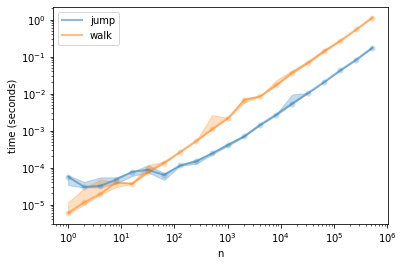

In [9]:
ax = T.plot_feature('n')
ax.set_xscale('log'); ax.set_yscale('log')

# Closing thoughts

Pros:
- The jump algorithm saves a ton of random variates and gives practical savings (at least, in my limited experiments).

Cons:
- The jump algorithm is harder to parallelize or vectorize, but it seems possible.
- If you aren't in a setting that requires a one-pass algorithm or some other special properties, you are probably better served by the two-pass algorithms since they have lower overhead because it doesn't call expensive functions like $\log$ and it uses a single random variate per sample.

Further reading: I have several posts on the topic of fast sampling algorithms, which might be of interest ([1](http://timvieira.github.io/blog/post/2016/11/21/heaps-for-incremental-computation/), [2](http://timvieira.github.io/blog/post/2016/07/04/fast-sigmoid-sampling/), [3](http://timvieira.github.io/blog/post/2014/08/01/gumbel-max-trick-and-weighted-reservoir-sampling/)).